In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Reading the data
df = pd.read_csv("/Users/nitishsai/Downloads/spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
df.tail()

,label,Text,label_enc
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will Ì_ b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0
5571,ham,Rofl. Its true to its name,0


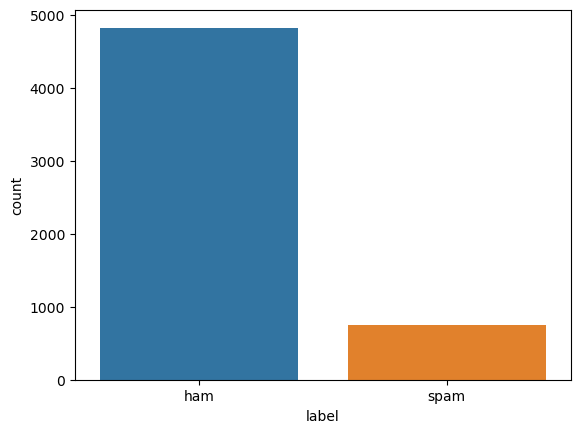

In [ ]:
sns.countplot(x=df['label'])
plt.show()

In [ ]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)


15


In [ ]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
    for word in sent.split():
        s.add(word)
total_words_length=len(s)
print(total_words_length)


15585


In [ ]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
	new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((4457,), (4457,), (1115,), (1115,))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)


MultinomialNB()

In [ ]:
nb_accuracy = accuracy_score(y_test, baseline_model.predict (X_test_vec))
print (nb_accuracy)
print(classification_report(y_test, baseline_model.predict(X_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



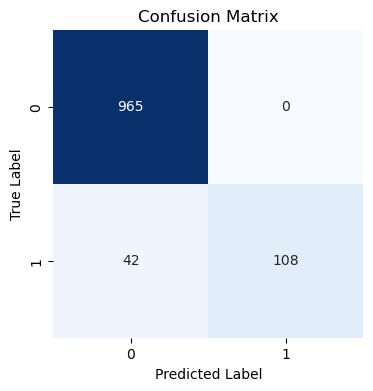

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Use the baseline_model to make predictions
y_pred = baseline_model.predict(X_test_vec)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Set the class labels (replace with your actual class labels)
class_labels = ["0", "1"]

# Create a figure and axis for the plot
plt.figure(figsize=(4, 4))

# Use Seaborn's heatmap to create the plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)

# Add labels and a title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()




In [ ]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)


In [ ]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)


In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])


In [ ]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128

In [ ]:
history_1 = model_1.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test),validation_steps=int(0.2*len(X_test)))

Epoch 1/5
140/140 [==============================] - 1s 7ms/step - loss: 0.6083 - accuracy: 0.9064 - val_loss: 0.5767 - val_accuracy: 0.9713
Epoch 2/5
140/140 [==============================] - 1s 6ms/step - loss: 0.5701 - accuracy: 0.9870 - val_loss: 0.5735 - val_accuracy: 0.9803
Epoch 3/5
140/140 [==============================] - 1s 6ms/step - loss: 0.5658 - accuracy: 0.9960 - val_loss: 0.5726 - val_accuracy: 0.9848
Epoch 4/5
140/140 [==============================] - 1s 6ms/step - loss: 0.5642 - accuracy: 0.9980 - val_loss: 0.5726 - val_accuracy: 0.9821
Epoch 5/5
140/140 [==============================] - 1s 6ms/step - loss: 0.5635 - accuracy: 0.9984 - val_loss: 0.5728 - val_accuracy: 0.9830


<Axes: >

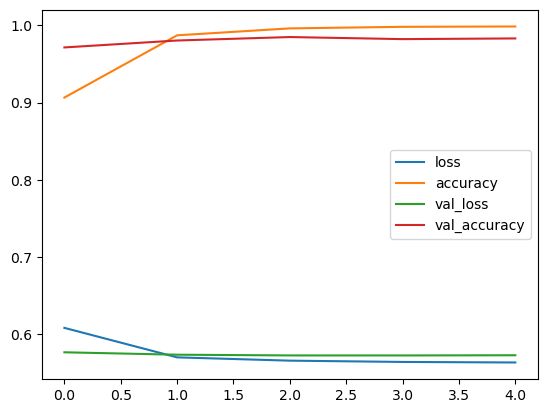

In [ ]:
pd.DataFrame (history_1.history).plot ()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
    model.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
def fit_model(model, epochs, X_train=X_train, y_train=y_train,X_test=X_test, y_test=y_test):
    '''
    fit the model with given epochs, train
    and test data
    '''
    history = model.fit(X_train,y_train,epochs=epochs,validation_data=(X_test, y_test),validation_steps=int(0.2*len(X_test)))
    return history

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy,
    precision, recall and f1-score
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {'accuracy': accuracy,'precision': precision,'recall': recall,'f1-score': f1}

    return model_results_dict


In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5) # fit the model


Epoch 1/5
140/140 [==============================] - 6s 24ms/step - loss: 0.0524 - accuracy: 0.9829 - val_loss: 0.1107 - val_accuracy: 0.9803
Epoch 2/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.0766 - val_accuracy: 0.9857
Epoch 3/5
140/140 [==============================] - 3s 21ms/step - loss: 9.4563e-05 - accuracy: 1.0000 - val_loss: 0.1170 - val_accuracy: 0.9839
Epoch 4/5
140/140 [==============================] - 3s 21ms/step - loss: 1.9798e-05 - accuracy: 1.0000 - val_loss: 0.1244 - val_accuracy: 0.9848
Epoch 5/5
140/140 [==============================] - 3s 21ms/step - loss: 1.1115e-05 - accuracy: 1.0000 - val_loss: 0.1296 - val_accuracy: 0.9848


In [ ]:
compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5) # fit the model

Epoch 1/5
140/140 [==============================] - 5s 24ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 0.1512 - val_accuracy: 0.9794
Epoch 2/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.1541 - val_accuracy: 0.9803
Epoch 3/5
140/140 [==============================] - 3s 20ms/step - loss: 4.2571e-06 - accuracy: 1.0000 - val_loss: 0.1607 - val_accuracy: 0.9803
Epoch 4/5
140/140 [==============================] - 3s 20ms/step - loss: 2.9061e-06 - accuracy: 1.0000 - val_loss: 0.1626 - val_accuracy: 0.9803
Epoch 5/5
140/140 [==============================] - 3s 21ms/step - loss: 2.5996e-06 - accuracy: 1.0000 - val_loss: 0.1650 - val_accuracy: 0.9803


In [ ]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                              'Custom-Vec-Embedding Model':model_1_results,
                              'Bidirectional-LSTM Model':model_2_results,
                             }).transpose()

total_results


35/35 [==============================] - 1s 3ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.977578,0.992126,0.840000,0.909747
Bidirectional-LSTM Model,0.980269,0.984848,0.866667,0.921986
